# Intro Task, Object Localization

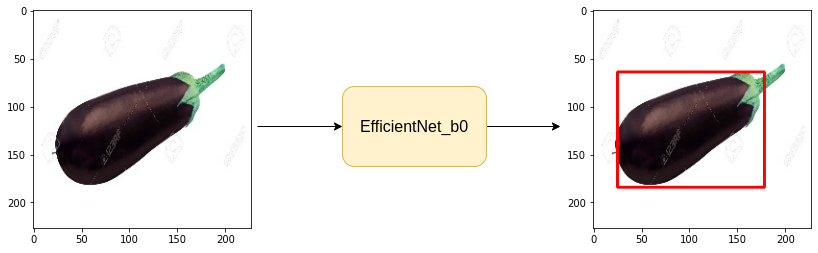

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm

!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-axr606yb
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-axr606yb
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.3 MB/s eta 0:00:00


In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 24.35 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
csv_file="/content/object-localization-dataset/train.csv"
data_dir="/content/object-localization-dataset"

device='cuda'
img_size=140
batch_size=16
lr=0.001
epochs=40
model_name='efficientnet_b0'

num_cor=4

In [ ]:
df=pd.read_csv(csv_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  186 non-null    object
 1   xmin      186 non-null    int64 
 2   ymin      186 non-null    int64 
 3   xmax      186 non-null    int64 
 4   ymax      186 non-null    int64 
 5   width     186 non-null    int64 
 6   height    186 non-null    int64 
 7   label     186 non-null    object
dtypes: int64(6), object(2)
memory usage: 11.8+ KB


# Understand the dataset

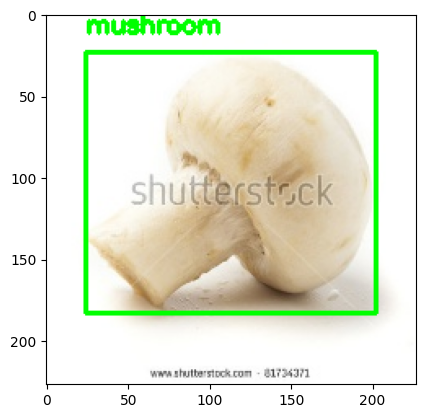

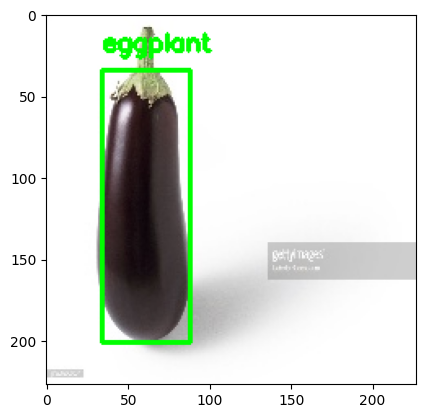

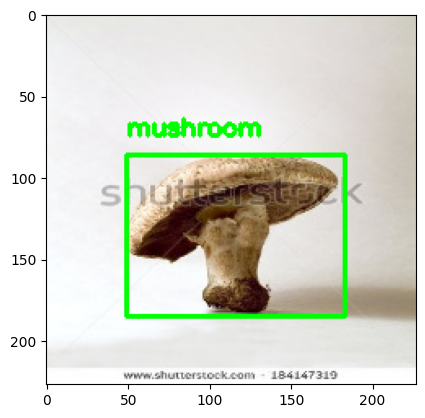

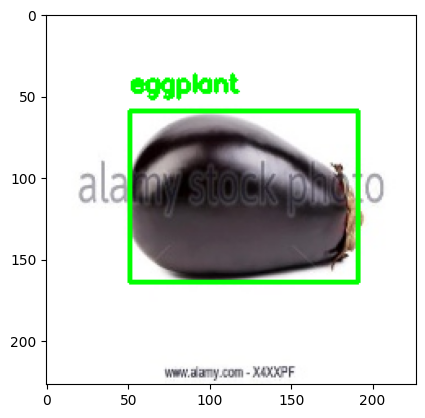

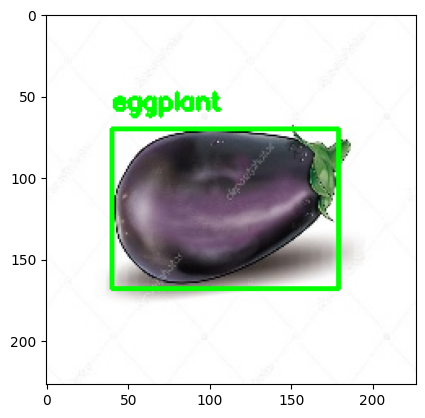

In [ ]:
for i in range(5):
  image=plt.imread(data_dir+'/'+str(df['img_path'][i]))
  box=df.iloc[i,1:5]
  label=df['label'][i]
  cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(0,255,0),2)
  cv2.putText(image,label,(box[0],box[1]-12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)
  plt.imshow(image)
  plt.show()

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)


# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs=A.Compose([
    A.Resize(img_size,img_size),
    A.HorizontalFlip(0.5),
    A.VerticalFlip(0.5),
    A.Rotate()
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

valid_augs=A.Compose([
    A.Resize(img_size,img_size),
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjectLocalDataset(torch.utils.data.Dataset):
  def __init__(self,df,augmentations=None):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    bbox=[self.df.iloc[idx,1:5]]
    img=plt.imread(data_dir+'/'+str(self.df.iloc[idx,0]))
    if self.augmentations:
      data=self.augmentations(image=img,bboxes=bbox,class_labels=[None])
      img=data['image']
      bbox=data['bboxes'][0]

    img=torch.from_numpy(img).permute(2,0,1)/255.0 #(C,H,W)
    bbox=torch.Tensor(bbox)

    return img,bbox

In [ ]:
train_set=ObjectLocalDataset(train_df,train_augs)
valid_set=ObjectLocalDataset(valid_df,valid_augs)

In [ ]:
print(len(train_set),len(valid_set))

148 38


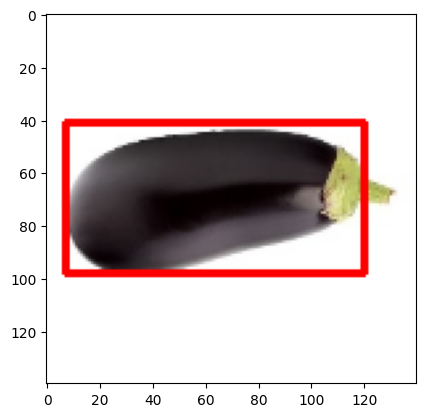

In [ ]:
img, bbox = train_set[17]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
validloader=torch.utils.data.DataLoader(valid_set,batch_size=batch_size,shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images,bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjectLocal(nn.Module):
  def __init__(self):
    super().__init__()
    self.backbone=timm.create_model(model_name,pretrained=True,num_classes=4)

  def forward(self,images:torch.tensor):
    return self.backbone(images)

In [ ]:
model=ObjectLocal()
model.to(device)

ObjectLocal(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

# Create Train and Eval Function

In [ ]:
def train(model,optimizer,loss_fn,train_loader):
  model.train()
  total_loss=0
  for img,gt_bbox in train_loader:

    bbox_pred=model(img.to(device))
    loss=loss_fn(bbox_pred.to(device),gt_bbox.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(train_loader)



In [ ]:
def valid(model,loss_fn,valid_loader):
  model.eval()
  total_loss=0
  with torch.no_grad():
    for img,gt_bbox in valid_loader:

      bbox_pred=model(img.to(device))
      loss=loss_fn(bbox_pred.to(device),gt_bbox.to(device))
      total_loss+=loss.item()

  return total_loss/len(valid_loader)

#Training Loop

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
loss_fn=nn.MSELoss()

In [ ]:
best_valid_loss=np.Inf

In [ ]:
for epoch in range(epochs):
  train_loss=train(model,optimizer,loss_fn,trainloader)
  valid_loss=valid(model,loss_fn,validloader)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("Model Saved")
    best_valid_loss=valid_loss

  print(f"Epoch: {epoch} | Train Loss: {train_loss} | Valid Loss: {valid_loss}")

Model Saved
Epoch: 0 | Train Loss: 1797.9534057617188 | Valid Loss: 2234.8282877604165
Model Saved
Epoch: 1 | Train Loss: 1019.5987426757813 | Valid Loss: 566.1480916341146
Model Saved
Epoch: 2 | Train Loss: 662.090234375 | Valid Loss: 295.9595133463542
Model Saved
Epoch: 3 | Train Loss: 447.25372314453125 | Valid Loss: 174.60857645670572
Model Saved
Epoch: 4 | Train Loss: 304.5129928588867 | Valid Loss: 145.54055531819662
Epoch: 5 | Train Loss: 255.1411117553711 | Valid Loss: 161.6804453531901
Epoch: 6 | Train Loss: 187.9993667602539 | Valid Loss: 168.30829111735025
Epoch: 7 | Train Loss: 138.0580047607422 | Valid Loss: 176.30206807454428
Epoch: 8 | Train Loss: 116.86918792724609 | Valid Loss: 193.65862528483072
Epoch: 9 | Train Loss: 79.95953941345215 | Valid Loss: 165.84472147623697
Model Saved
Epoch: 10 | Train Loss: 86.0731430053711 | Valid Loss: 140.22207895914713
Model Saved
Epoch: 11 | Train Loss: 63.29035568237305 | Valid Loss: 118.97674814860027
Model Saved
Epoch: 12 | Train 

#Inference

In [ ]:
import utils

In [ ]:
model_infer=ObjectLocal()
model_infer.load_state_dict(torch.load('best_model.pt'))
model_infer.eval()

ObjectLocal(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

tensor([ 33.7062,  20.4224, 128.4405, 107.5120])
(140, 140, 3)


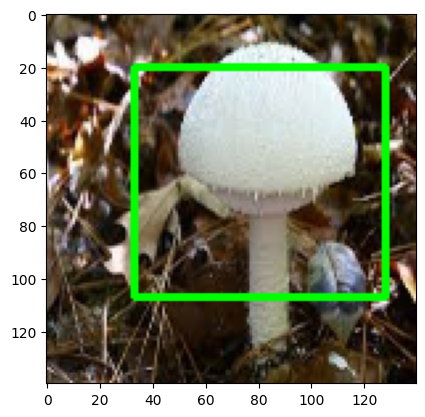

In [ ]:


image_path="/content/download (1).jpg"

with torch.no_grad():
  image=plt.imread(image_path)
  image=cv2.resize(image,(img_size,img_size))/255.0
  image=torch.tensor(image,dtype=torch.float32)
  image=image.unsqueeze(0)
  box=model_infer(image.permute((0,3,1,2)))
  box=box[0]
  print(box)
  image=image.squeeze().numpy()
  print(image.shape)
  cv2.rectangle(image,(int(box[0]),int(box[1])),(int(box[2]),int(box[3])),(0,255,0),2)
  plt.imshow(image)


# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya